In [1]:
import numpy as np 
import pandas as pd 
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from unet import UNet
import time
import cv2
%matplotlib inline
dsb_data_dir = os.path.join('.', 'data')
stage_label = 'data/stage1'

In [2]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_df['ImageId'] = img_df['path'].map(lambda in_path: in_path.split('/')[-3])
img_df['ImageType'] = img_df['path'].map(lambda in_path: in_path.split('/')[-2])
img_df['TrainingSplit'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[1])
img_df['Stage'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[0])
img_df.sample(3)

,path,ImageId,ImageType,TrainingSplit,Stage
1730,./data/stage1_train/37ed50eea5a1e0bade3e675379...,37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f3656...,masks,train,stage1
1372,./data/stage1_train/f6863b83d75e5927b30e2e3264...,f6863b83d75e5927b30e2e326405b588293283c25aaef2...,masks,train,stage1
27046,./data/stage1_train/4ca5081854df7bbcaa4934fcf3...,4ca5081854df7bbcaa4934fcf34318f82733a0f8c05b94...,masks,train,stage1


In [3]:
# np.stack to squash multidim-list to ndarray
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    img = [imread(c_img) for c_img in in_img_list]
    img_stack = np.stack(img, 0)
    img_sum = np.sum(img_stack, 0)
#     return img_sum/255.0
    return img_sum

GRID_SIZE = 8
def rgb_clahe(in_rgb_img): 
    bgr = in_rgb_img[:,:,[2,1,0]] # flip r and b
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(GRID_SIZE,GRID_SIZE))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr[:,:,[2,1,0]]

def rgb_clahe_justl(in_rgb_img): 
    in_rgb_img = in_rgb_img.astype(np.uint8)
    bgr = in_rgb_img[:,:,[2,1,0]] # flip r and b
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(GRID_SIZE,GRID_SIZE))
    return clahe.apply(lab[:,:,0])

def img_invert(in_img):
    return (255-in_img) if in_img.mean()>127 else in_img

In [4]:
#train data
train_df = img_df[img_df.TrainingSplit == 'train']
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows[n_rows.ImageType == 'masks']['path'].values.tolist()
    c_row['images'] = n_rows[n_rows.ImageType == 'images']['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS].astype(np.uint8))
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(np.uint8))
train_img_df['clache'] = train_img_df['images'].map(lambda x: rgb_clahe(x).astype(np.uint8))
train_img_df['clache_l'] = train_img_df['images'].map(lambda x: rgb_clahe_justl(x)).map(lambda x: img_invert(x).astype(np.uint8))                                                                                             
train_img_df.head(3)                                                                                             
# train_img_df.sample(3)

,ImageId,Stage,images,masks,clache,clache_l
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,stage1,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[13, 13, 13], [13, 13, 13], [13, 13, 13], [1...","[[9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7,..."
1,003cee89357d9fe13516167fd67b609a164651b2193458...,stage1,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [4, 4, 4], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[13, 13, 13], [13, 13, 13], [13, 13, 13], [8...","[[9, 9, 9, 6, 13, 9, 13, 6, 9, 9, 6, 6, 9, 6, ..."
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,stage1,"[[[130, 62, 165], [126, 56, 162], [121, 55, 16...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[120, 52, 155], [114, 45, 151], [108, 43, 14...","[[164, 170, 173, 173, 174, 178, 177, 170, 159,..."


In [5]:
#test data
test_df = img_df[img_df.TrainingSplit == 'test']
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows[n_rows.ImageType == 'images']['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS].astype(np.uint8))
test_img_df['clache'] = test_img_df['images'].map(lambda x: rgb_clahe(x).astype(np.uint8))
test_img_df['clache_l'] = test_img_df['images'].map(lambda x: rgb_clahe_justl(x)).map(lambda x: img_invert(x).astype(np.uint8))                                                                                               
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(3)

65 images to process


,ImageId,Stage,images,clache,clache_l
16,31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab...,stage1,"[[[14, 14, 14], [12, 12, 12], [13, 13, 13], [1...","[[[21, 21, 21], [18, 18, 18], [18, 18, 18], [1...","[[17, 14, 14, 14, 14, 14, 14, 20, 17, 17, 14, ..."
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,stage1,"[[[49, 49, 49], [39, 39, 39], [33, 33, 33], [2...","[[[90, 90, 90], [66, 66, 66], [53, 52, 52], [4...","[[97, 71, 56, 45, 39, 33, 25, 22, 22, 20, 17, ..."
19,3c4c675825f7509877bc10497f498c9a2e3433bf922bd8...,stage1,"[[[225, 235, 214], [222, 235, 212], [225, 235,...","[[[201, 211, 190], [199, 211, 188], [201, 211,...","[[43, 43, 43, 45, 48, 50, 50, 50, 50, 50, 50, ..."


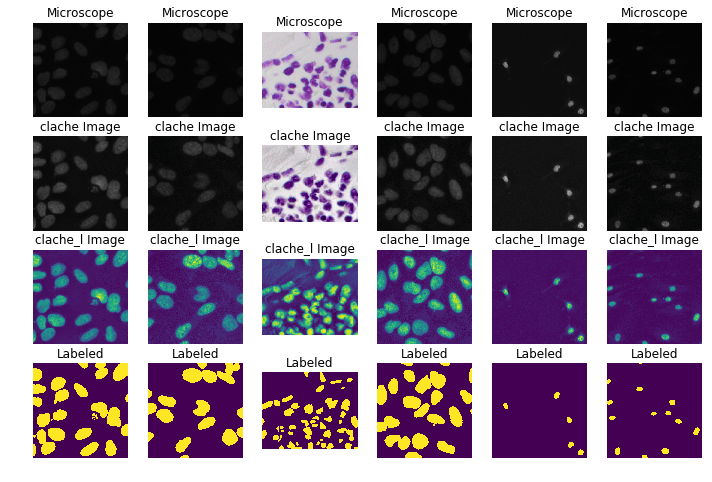

In [6]:
n_img = 6
fig, m_axs = plt.subplots(4, n_img, figsize = (12, 8))
for (_, c_row), (c_im,c_cla, c_cla_l, c_lab) in zip(train_img_df.sample(n_img).iterrows(), m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_cla.imshow(c_row['clache'])
    c_cla.axis('off')
    c_cla.set_title('clache Image')
    
    c_cla_l.imshow(c_row['clache_l'])
    c_cla_l.axis('off')
    c_cla_l.set_title('clache_l Image')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [7]:
train = train_img_df.sample(frac=0.9)
val = train_img_df[~train_img_df['ImageId'].isin(train['ImageId'])]
test = test_img_df
print(len(train), len(val), len(test))

603 67 65


In [8]:
#data loader
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
import random

class NucleusDataset(data.Dataset):
    def __init__(self, df, transform_train=None, transform_target=None, training=True):
        self.df = df
        self.transform_train = transform_train
        self.transform_target = transform_target
        self.training = training
#         self.normalize = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df.iloc[index]['clache']
        image = Image.fromarray(image)
        if self.training:
            mask = self.df.iloc[index]['masks']
            mask = Image.fromarray(mask)
        
            seed = np.random.randint(123456) 
            if self.transform_train:
                self.set_seed(seed)
                image = self.transform_train(image)
#                 image = self.normalize(image)
                
                #mask transform
                self.set_seed(seed)
                mask = self.transform_target(mask)
            
            return image, mask
        else:
            if self.transform_train:
                image = self.transform_train(image)
#                 image = self.normalize(image)
            return image
    
    def set_seed(self,seed):
        random.seed(seed)
        np.random.seed(seed)

In [9]:
CROP_SIZE = 224
NUM_WORKERS = 2
BATCH_SIZE = 8
SHUFFLE = True

EPOCH = 3

transform_train = transforms.Compose([ 
        transforms.RandomCrop(CROP_SIZE),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.ToTensor()
])

transform_target = transforms.Compose([
        transforms.RandomCrop(CROP_SIZE),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor()    
])

transform_test = transforms.Compose([ 
        transforms.ToTensor()])


nucleus_dataset_train = NucleusDataset(train, transform_train=transform_train, transform_target=transform_target)
nucleus_dataset_val = NucleusDataset(val, transform_train=transform_train, transform_target=transform_target)
nucleus_dataset_test = NucleusDataset(test, transform_train=transform_test, training=False)

train_dl = torch.utils.data.DataLoader(dataset=nucleus_dataset_train, batch_size=BATCH_SIZE,
                                                shuffle=SHUFFLE, num_workers=NUM_WORKERS)

val_dl = torch.utils.data.DataLoader(dataset=nucleus_dataset_val, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=NUM_WORKERS)

test_dl = torch.utils.data.DataLoader(dataset=nucleus_dataset_test, batch_size=1,
                                                shuffle=False, num_workers=NUM_WORKERS)


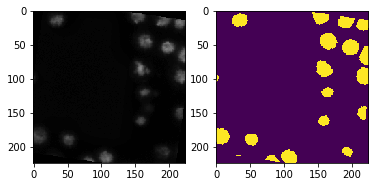

In [10]:
i,m =nucleus_dataset_train[0]
pilTrans = transforms.ToPILImage()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(pilTrans(i)))
axes[1].imshow(np.asarray(pilTrans(m)))

In [11]:
image, mask = iter(train_dl).next()
print(image.shape, mask.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
from torch.optim import lr_scheduler

use_gpu = torch.cuda.is_available()

#Loss
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss2d(weight, size_average)

    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets)
    
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)        


def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_loss = 99999
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                outputs = F.sigmoid(outputs)
                
                loss = criterion(outputs.view(-1), labels.squeeze(1).view(-1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
# 
            if phase == 'valid' and valid_epoch_loss < best_loss:
                best_loss = valid_epoch_loss
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} valid loss: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, 
                valid_epoch_loss))
        print('learning rate: ', scheduler.get_lr())
            
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [26]:
LEARNING_RATE = 0.001

unet = UNet(1, depth=5, in_channels=3, merge_mode='concat', up_mode='transpose')

if use_gpu:
    unet = unet.cuda()

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(unet.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

dloaders = {'train':train_dl, 'valid':val_dl}

In [28]:
start_time = time.time()
model = train_model(dloaders, unet, criterion, optimizer, exp_lr_scheduler, num_epochs=50)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/49] train loss: 0.0108 valid loss: 0.0123
learning rate:  [1.0000000000000003e-05]
Epoch [1/49] train loss: 0.0102 valid loss: 0.0123
learning rate:  [1.0000000000000003e-05]
Epoch [2/49] train loss: 0.0100 valid loss: 0.0124
learning rate:  [1.0000000000000003e-05]
Epoch [3/49] train loss: 0.0106 valid loss: 0.0123
learning rate:  [1.0000000000000003e-05]
Epoch [4/49] train loss: 0.0100 valid loss: 0.0122
learning rate:  [1.0000000000000003e-05]
Epoch [5/49] train loss: 0.0099 valid loss: 0.0122
learning rate:  [1.0000000000000003e-05]
Epoch [6/49] train loss: 0.0104 valid loss: 0.0122
learning rate:  [1.0000000000000003e-05]
Epoch [7/49] train loss: 0.0096 valid loss: 0.0122
learning rate:  [1.0000000000000003e-05]
Epoch [8/49] train loss: 0.0098 valid loss: 0.0122
learning rate:  [1.0000000000000003e-05]
Epoch [9/49] train loss: 0.0102 valid loss: 0.0121
learning rate:  [1.0000000000000003e-05]
Epoch [10/49] train loss: 0.0098 valid loss: 0.0121
learning rate:  [1.000000000

In [42]:
#save model 
torch.save(model.state_dict(), 'unet3.pth')

In [19]:
#load weight
load_weight = torch.load('unet3.pth')
unet.load_state_dict(load_weight)

In [30]:
itr = iter(train_dl)

In [31]:
imgs, masks = itr.next()
pred_mask = unet(Variable(imgs.cuda(),volatile = True))
pred_mask = F.sigmoid(pred_mask)
masks = Variable(masks.cuda(), volatile = True)

In [32]:
print('loss: ',criterion(pred_mask.view(-1), masks.view(-1)).data[0])

loss:  0.08939745277166367


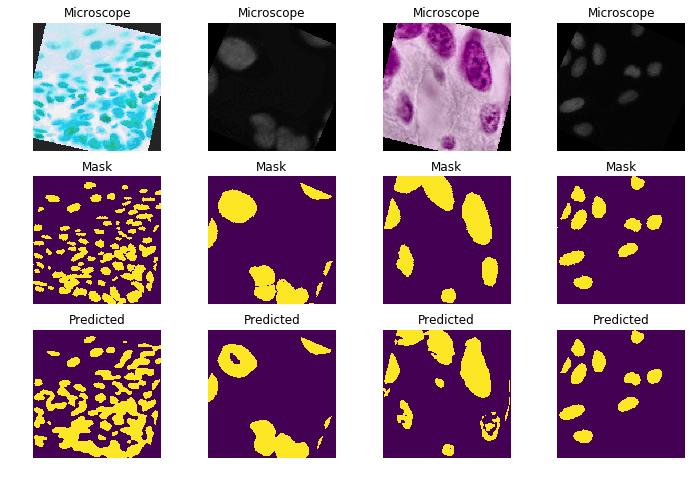

In [33]:
img_dict_list = []
n_img = 4
for i in range(n_img):
    img = np.asarray(pilTrans(imgs[i]))
    mask = masks[i][0].data.cpu().numpy()
    pred = (pred_mask[i][0].data.cpu() > 0.5).numpy()
    img_dict_list.append({'img':img, 'mask':mask,'pred':pred})

fig, m_axs = plt.subplots(3, n_img, figsize = (12, 8))
for c_row, (c_im, c_mask, c_pred) in zip(img_dict_list, m_axs.T):
    c_im.imshow(c_row['img'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_mask.imshow(c_row['mask'])
    c_mask.axis('off')
    c_mask.set_title('Mask')
    
    c_pred.imshow(c_row['pred'])
    c_pred.axis('off')
    c_pred.set_title('Predicted')

In [34]:
outputs = []
for i, data in enumerate(test_dl):
    img = data
    img = Variable(img.cuda(), volatile = True)
    
#     print(i, img.shape)
    output = unet(img)
    output = F.sigmoid(output)
    output_mask = output[0][0].data > 0.5
#     plt.imshow(output_mask)
    print(i, output_mask.shape)
    outputs.append(output_mask)
    
    

0 torch.Size([256, 256])
1 torch.Size([519, 253])
2 torch.Size([256, 256])
3 torch.Size([256, 256])
4 torch.Size([256, 256])
5 torch.Size([512, 680])
6 torch.Size([512, 640])
7 torch.Size([512, 680])
8 torch.Size([512, 640])
9 torch.Size([256, 256])
10 torch.Size([519, 162])
11 torch.Size([512, 640])
12 torch.Size([524, 348])
13 torch.Size([256, 256])
14 torch.Size([512, 680])
15 torch.Size([256, 256])
16 torch.Size([256, 256])
17 torch.Size([519, 253])
18 torch.Size([256, 256])
19 torch.Size([524, 348])
20 torch.Size([520, 348])
21 torch.Size([260, 347])
22 torch.Size([512, 680])
23 torch.Size([256, 256])
24 torch.Size([512, 680])
25 torch.Size([256, 256])
26 torch.Size([390, 239])
27 torch.Size([512, 640])
28 torch.Size([256, 256])
29 torch.Size([256, 256])
30 torch.Size([260, 347])
31 torch.Size([256, 256])
32 torch.Size([520, 348])
33 torch.Size([512, 640])
34 torch.Size([256, 256])
35 torch.Size([256, 256])
36 torch.Size([260, 347])
37 torch.Size([520, 348])
38 torch.Size([512, 64

In [35]:
outputs_numpy = [o.cpu().numpy() for o in outputs]

In [36]:
test_img_df['masks'] = pd.Series(outputs_numpy)
test_img_df.sample(3)

,ImageId,Stage,images,clache,clache_l,masks
21,43a71aeb641faa18742cb826772a8566c6c947d7050f9a...,stage1,"[[[22, 22, 22], [22, 22, 22], [24, 24, 24], [2...","[[[29, 29, 29], [29, 29, 29], [32, 32, 32], [3...","[[27, 27, 31, 31, 24, 13, 21, 31, 24, 31, 27, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,stage1,"[[[115, 52, 104], [117, 52, 102], [117, 52, 10...","[[[145, 80, 133], [147, 80, 130], [148, 81, 13...","[[144, 144, 142, 144, 142, 144, 137, 137, 139,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
51,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,stage1,"[[[227, 231, 201], [225, 231, 201], [223, 227,...","[[[212, 215, 186], [210, 216, 186], [203, 208,...","[[38, 38, 45, 66, 82, 104, 122, 132, 141, 147,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


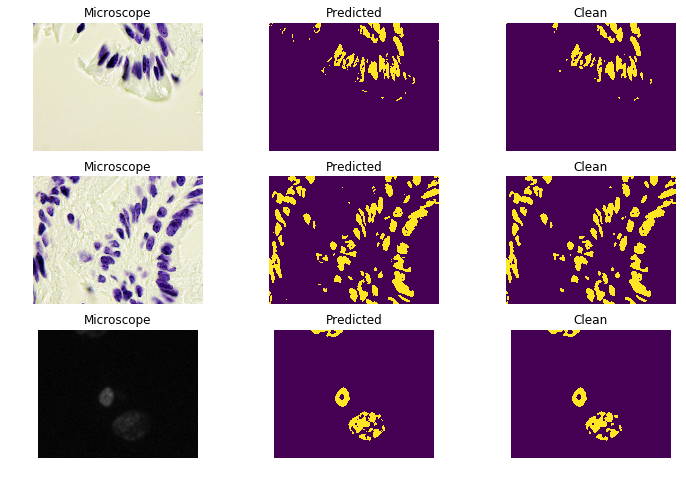

In [37]:
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

n_img = 3
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 8))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')
    

# Check RLE
Check that our approach for RLE encoding (stolen from [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)) works

In [38]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

# Calculate RLE for all the masks
Here we generate the RLE for all the masks and output the the results to a table. We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions, etc)

In [39]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [40]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

2917 regions found for 65 images


,EncodedPixels,ImageId
338,61822 7 62339 11 62858 12 63376 15 63896 18 64...,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...
535,345818 4 346328 8 346342 2 346839 11 346852 6 ...,259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67...
744,1561 1 2081 3 2601 3 3121 4 3641 6 4161 7 4681...,432f367a4c5b5674de2e2977744d10289a064e5704b21a...


In [41]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('unet3_predictions.csv', index = False)